In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
from keras.regularizers import l2
        

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [5]:
df = pd.read_parquet('../data/btcusd_preprcd_with_regimes_and_classy.parquet')
df = df[df['smoothed_regimes'] == 1]
df.dropna(inplace=True)

In [6]:
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 257888 entries, 47 to 292662
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              257888 non-null  float64
 1   high              257888 non-null  float64
 2   low               257888 non-null  float64
 3   close             257888 non-null  float64
 4   BB_up_diff        257888 non-null  float64
 5   BB_down_diff      257888 non-null  float64
 6   OBV_Z             257888 non-null  float64
 7   MACD_Histogram    257888 non-null  float64
 8   RSI               257888 non-null  float64
 9   CCI               257888 non-null  float64
 10  predict_trend     257888 non-null  float64
 11  regime            257888 non-null  float64
 12  smoothed_regimes  257888 non-null  float64
 13  classy            257888 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 29.5 MB
None


open                0
high                0
low                 0
close               0
BB_up_diff          0
BB_down_diff        0
OBV_Z               0
MACD_Histogram      0
RSI                 0
CCI                 0
predict_trend       0
regime              0
smoothed_regimes    0
classy              0
dtype: int64

In [7]:
def preprocess_data(train_df):
    # Calculate log returns for price columns
    for col in ['open', 'high', 'low', 'close']:
        train_df[f'{col}_log_return'] = np.log(train_df[col] / train_df[col].shift(1))
    
    # Create additional features
    train_df['price_mean'] = train_df[['open', 'high', 'low', 'close']].mean(axis=1)
    train_df['price_std'] = train_df[['open', 'high', 'low', 'close']].std(axis=1)
    train_df['price_range'] = train_df['high'] - train_df['low']
    
    # Standard scaling for MACD and CCI
    std_cols = ['MACD_Histogram', 'CCI']
    std_scaler = StandardScaler().fit(train_df[std_cols])
    train_df[std_cols] = std_scaler.transform(train_df[std_cols])
    
    # Normalize RSI to focus on the 30–70 range
    train_df['RSI'] = np.clip(train_df['RSI'], 30, 70)
    rsi_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['RSI']])
    train_df['RSI'] = rsi_scaler.transform(train_df[['RSI']])
    
    # Add lagged features for RSI, MACD, CCI, and predict_trend
    for col in ['RSI', 'MACD_Histogram', 'CCI', 'predict_trend']:
        for lag in range(1, 10):  # Add 4 lagged intervals
            train_df[f'{col}_lag_{lag}'] = train_df[col].shift(lag)
    
    # Drop rows with NaN values (caused by lagging)
    train_df.dropna(inplace=True)
    
    return train_df

In [8]:
df = preprocess_data(df)
# sc = StandardScaler()
# df['predict_trend'] = sc.fit_transform(df[['predict_trend']])

In [9]:
df.head()

,open,high,low,close,BB_up_diff,BB_down_diff,OBV_Z,MACD_Histogram,RSI,CCI,...,CCI_lag_9,predict_trend_lag_1,predict_trend_lag_2,predict_trend_lag_3,predict_trend_lag_4,predict_trend_lag_5,predict_trend_lag_6,predict_trend_lag_7,predict_trend_lag_8,predict_trend_lag_9
56,658.74,665.00,655.79,659.10,-2.529762,-20.448238,1.223019,0.042641,1.0,1.771480,...,0.585970,-0.259333,10.044667,6.076667,4.018000,2.892000,1.628667,-0.025333,-1.264000,1.648667
57,660.00,665.51,654.36,657.43,0.514464,-18.609464,0.380160,0.043436,1.0,1.246238,...,0.948745,-1.436667,-0.259333,10.044667,6.076667,4.018000,2.892000,1.628667,-0.025333,-1.264000
58,656.48,658.10,655.95,657.90,1.401129,-19.055129,0.393569,0.042370,1.0,1.100578,...,0.638667,0.006667,-1.436667,-0.259333,10.044667,6.076667,4.018000,2.892000,1.628667,-0.025333
59,657.06,658.08,656.80,657.98,2.429928,-18.799928,0.415015,0.039361,1.0,0.942582,...,0.458955,-1.070000,0.006667,-1.436667,-0.259333,10.044667,6.076667,4.018000,2.892000,1.628667
60,657.39,659.70,657.39,658.88,2.777287,-19.873287,0.586010,0.036849,1.0,0.927737,...,0.495102,-2.020667,-1.070000,0.006667,-1.436667,-0.259333,10.044667,6.076667,4.018000,2.892000


In [10]:
y = df['classy']
x = df.drop(columns=['predict_trend', 'classy'])
x_train = x[:int(len(x)*0.6)]
y_train = y[:int(len(x)*0.6)]
x_val = x[int(len(x)*0.6):int(len(x)*0.8)]
y_val = y[int(len(x)*0.6):int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]
y_test = y[int(len(x)*0.8):]

In [11]:
x_train = np.nan_to_num(x_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
x_val = np.nan_to_num(x_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

In [12]:
y_train.shape

(154727,)

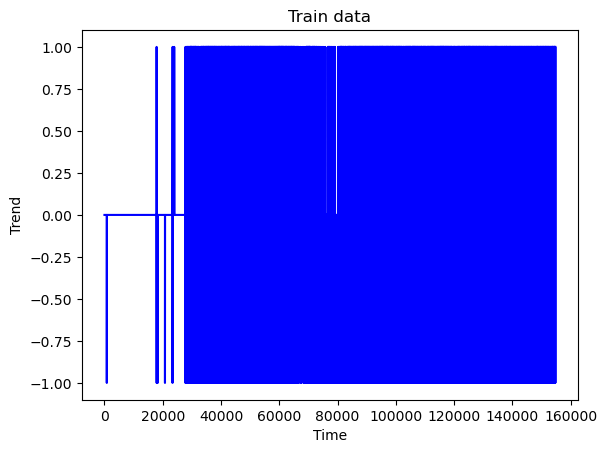

In [13]:
sns.lineplot(data=y_train, color='blue')

plt.title('Train data')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()


In [14]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

In [15]:
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(LSTM(16, activation='tanh', return_sequences=False))
# model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2025-03-21 01:09:17.447331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-21 01:09:17.447356: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-21 01:09:17.447370: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-21 01:09:17.447385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-21 01:09:17.447395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

In [16]:
from keras.utils import to_categorical

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Train the model with one-hot encoded labels
model.fit(x_train, y_train_one_hot, batch_size=32, epochs=5, validation_data=(x_val, y_val_one_hot), verbose=1)

Epoch 1/5


2025-03-21 01:09:17.954168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-21 01:09:17.956083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4836/4836 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7371 - loss: 0.6097

2025-03-21 01:10:26.153347: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4836/4836 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.7371 - loss: 0.6097 - val_accuracy: 0.5817 - val_loss: 0.9035
Epoch 2/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 87s 18ms/step - accuracy: 0.7749 - loss: 0.5260 - val_accuracy: 0.6136 - val_loss: 0.8596
Epoch 3/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 87s 18ms/step - accuracy: 0.7870 - loss: 0.4931 - val_accuracy: 0.6450 - val_loss: 0.7809
Epoch 4/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 87s 18ms/step - accuracy: 0.8009 - loss: 0.4660 - val_accuracy: 0.6617 - val_loss: 0.7563
Epoch 5/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - accuracy: 0.8075 - loss: 0.4502 - val_accuracy: 0.6554 - val_loss: 0.7495


In [17]:
model.save('../models/sideways_market_classy_model2.h5')

In [18]:
# from keras.metrics import MeanSquaredError

# custom_objects = {'mse': MeanSquaredError()}

# model_n = tf.keras.models.load_model('../models/sideways_market_model.h5', custom_objects=custom_objects)

y_pred = model.predict(x_test)


   1/1612 ━━━━━━━━━━━━━━━━━━━━ 2:21 88ms/step

2025-03-21 01:16:29.530723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [19]:
y_test.reset_index(inplace=True, drop=True)

In [20]:
print(y_pred[0])
print(y_test[0])


[0.01691577 0.97244555 0.0106387 ]
1


In [21]:
# y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
# y_test = sc.inverse_transform(np.array(y_test).reshape(-1, 1))

In [22]:
print("y_pred shape:", y_pred.shape)
print("y_val_one_hot shape:", y_val_one_hot.shape)

y_pred shape: (51576, 3)
y_val_one_hot shape: (51576, 3)


In [23]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

y_pred = y_pred[:y_val_one_hot.shape[0]]
# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val_one_hot, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes, target_names=["Class -1", "Class 0", "Class 1"]))

Accuracy: 0.3098921979215139
Classification Report:
              precision    recall  f1-score   support

    Class -1       0.15      0.10      0.12     14385
     Class 0       0.36      0.34      0.35     18747
     Class 1       0.34      0.44      0.38     18444

    accuracy                           0.31     51576
   macro avg       0.28      0.29      0.28     51576
weighted avg       0.29      0.31      0.30     51576



In [24]:
threshold = 500
signals_pred = np.where(y_pred > threshold, 1, np.where(y_pred < -threshold, -1, 0)).astype(int)
signals_test = np.where(y_test > threshold, 1, np.where(y_test < -threshold, -1, 0)).astype(int)

In [25]:
data = pd.DataFrame({
    'Index': range(len(y_test)),
    'y_test': y_test.flatten(),  # Use .values to get NumPy array
    'y_pred': y_pred.flatten()   # Use .values to get NumPy array
})

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_test', label='Actual (y_test)', color='blue')
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

AttributeError: 'Series' object has no attribute 'flatten'

In [ ]:
print("Unique values in signals_test:", np.unique(signals_test))
print("Unique values in signals_pred:", np.unique(signals_pred))

Unique values in signals_test: [-1  0  1]
Unique values in signals_pred: [-1  0  1]


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(signals_test, signals_pred, labels=[-1, 0, 1]))
print(confusion_matrix(signals_test, signals_pred, labels=[-1, 0, 1]))

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets